# Mercari Price Suggestion Challenge
* url: https://www.kaggle.com/c/mercari-price-suggestion-challenge

### import module

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go

import math
from collections import Counter, defaultdict

### data exploration

In [2]:
train = pd.read_csv('sample_data/train.tsv', sep='\t')
test = pd.read_csv('sample_data/test.tsv', sep='\t')
submission = pd.read_csv('sample_data/sample_submission.csv', sep=',')

In [3]:
train = pd.read_csv('data/train.tsv', sep='\t')
# test = pd.read_csv('data/test.tsv', sep='\t')

In [4]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [5]:
submission.head(3)

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738


In [6]:
train.shape

(1482535, 8)

In [7]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [8]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

### Helper Function

In [9]:
def log(l, slot=False):
    for x in l:
        x += 1
        if slot: 
            result = math.ceil(math.log(x, 2))
        else: 
            result = math.log(x, 2)
        yield result

def price_scale(l, n=500):
    for x in l:
        if x > n: yield n
        else: yield x

In [10]:
log_price = list(log(train.price))
log_price_slot = list(log(train.price, slot=True))
train['log_price_slot'] = log_price_slot
train['log_price'] = log_price

In [11]:
train['log_price_slot'].value_counts()

4     515105
5     490311
6     223163
3     132218
7      74964
8      21247
2      18703
9       4924
10       881
0        874
11       145
Name: log_price_slot, dtype: int64

### Pricing and Item Condition ID

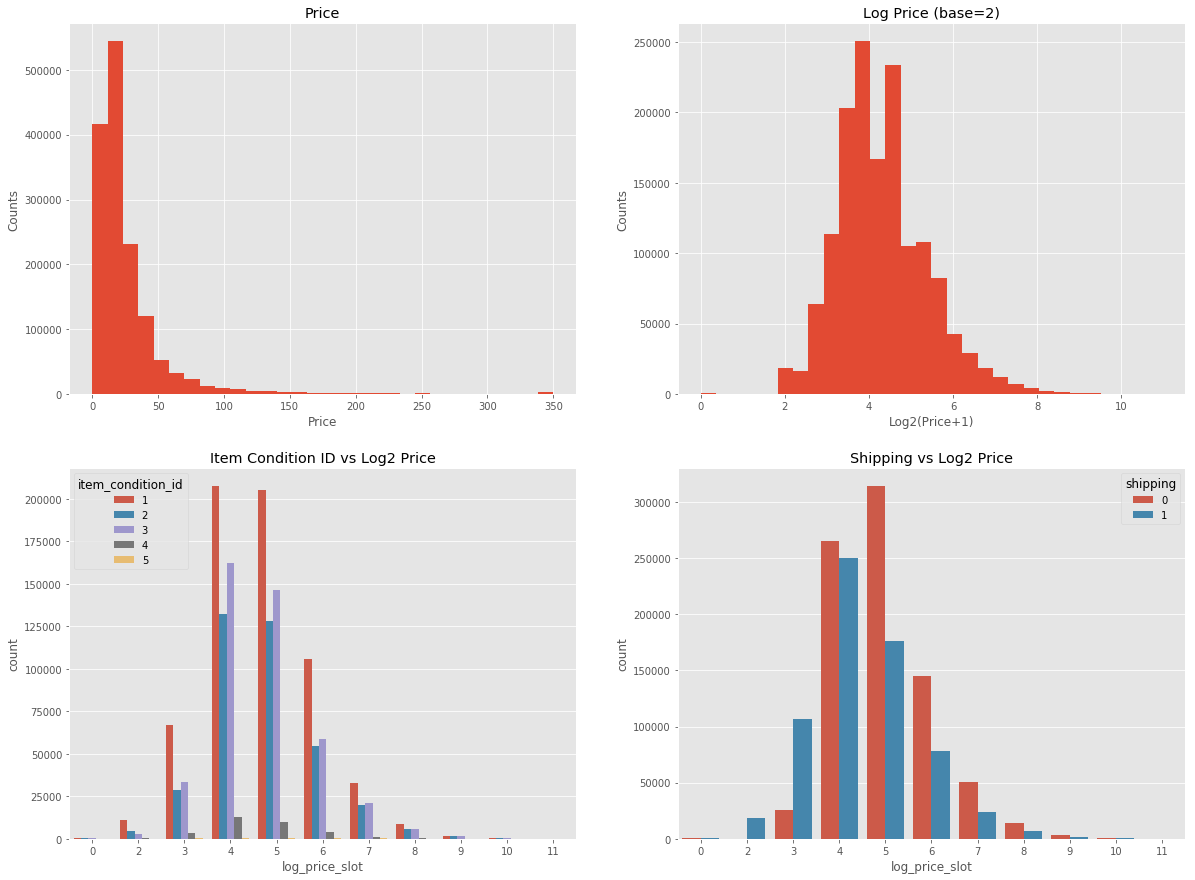

In [12]:
f,ax=plt.subplots(2,2,figsize=(20,15))

ax[0,0].hist(list(price_scale(train.price, n=350)), bins = 30,label = 'price')
ax[0,0].set_title("Price")
ax[0,0].set_xlabel("Price")
ax[0,0].set_ylabel("Counts")

ax[0,1].hist('log_price', bins = 30,label='price', data=train)
ax[0,1].set_title("Log Price (base=2)")
ax[0,1].set_xlabel("Log2(Price+1)")
ax[0,1].set_ylabel("Counts")

sns.countplot('log_price_slot', hue='item_condition_id', data=train, ax=ax[1,0])
ax[1,0].set_title('Item Condition ID vs Log2 Price')
sns.countplot('log_price_slot', hue='shipping',data=train,ax=ax[1,1])
ax[1,1].set_title('Shipping vs Log2 Price')
plt.show()

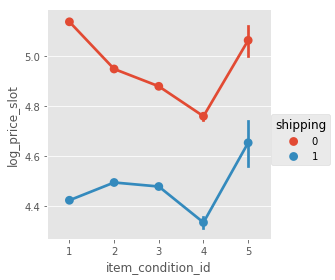

In [13]:
# sns.factorplot(log_price_slot, 'item_condition_id' ,hue='shipping',col='', data=train)
sns.factorplot('item_condition_id', 'log_price_slot' ,hue='shipping', data=train)
plt.show()

In [14]:
print("Item Condition ID vs Shipping")
pd.crosstab(train.shipping,train.item_condition_id,margins=False).style.background_gradient(cmap='summer_r')

Item Condition ID vs Shipping


item_condition_id,1,2,3,4,5
shipping,,,,,
0,280107,232509,283691,21603,1525
1,360442,142970,148470,10359,859


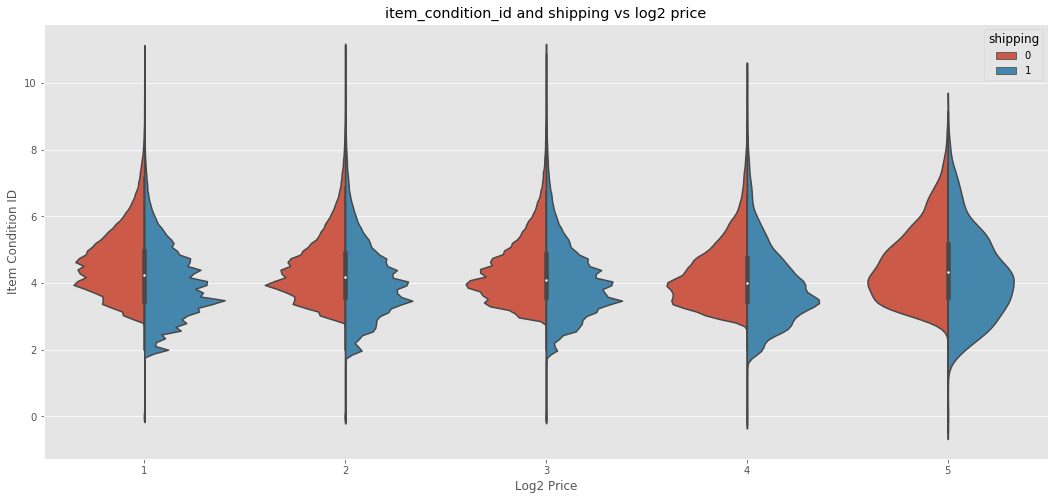

In [15]:
f,ax=plt.subplots(figsize=(18,8))
sns.violinplot(train.item_condition_id, log_price, hue=train.shipping, split=True)
ax.set_title('item_condition_id and shipping vs log2 price')
ax.set_xlabel("Log2 Price")
ax.set_ylabel("Item Condition ID")
plt.show()

### Brand Name

In [20]:
def brand_None(x):
    try: # x is str
        len(x)
        return x
    except: # x is NaN
        return "None"

def avg(l):
    return sum(l)/len(l)

def median(l):
    l = np.array(l)
    return np.median(l)

def brand_dict2Series(d):
    brand, price = list(zip(*d.items()))
    result = Series(list(price), index=list(brand))
    result = result.sort_values(ascending=False)
    return result
    
brand_num = len(train.brand_name.value_counts())
print("There are {} brand in this dataset".format(brand_num))

train['brand'] = train.brand_name.apply(brand_None)
brand_null_num = (train['brand'] == "None").sum()
print("There are {} null in Brand Names".format(brand_null_num))

train.brand_name.value_counts()[:5]

There are 4809 brand in this dataset
There are 632682 null in Brand Names


PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
Name: brand_name, dtype: int64

<br>
#### brand vs price
* there are many outliers
    * use <b>median price</b> rather than average price on each brand
<br>

In [17]:
def brand_box_plot(d, show=None):
    """brand vs price box plot
    input:
        d = dictionary {brand_name: [price1, price2, .....]}
        show = only show N instances in the plot (show all if None)
    output:
        fig = brand vs price box plot
    """
    data = []
    counter = 0
    for k, v in brand_price.items():
        data.append( go.Box(y=v, name=k) )
        counter += 1
        if counter == 10: break
            
    layout= go.Layout(
        title= 'Brand vs Price box plot',
        hovermode= 'closest',
        xaxis= dict(
            title= 'Brand Name',
            ticklen= 5,
            zeroline= False,
            gridwidth= 2,
        ),
        yaxis=dict(
            title= 'Price',
            ticklen= 5,
            gridwidth= 2,
        ),
        showlegend= False
    )
    fig= go.Figure(data=data, layout=layout)
    return fig

In [18]:
brand_price = defaultdict(list)
for brand, price in zip(train.brand, train.price):
    brand_price[brand].append(price)

fig = brand_box_plot(brand_price, show=50)
py.iplot(fig)

In [21]:
brand_price_median_dict = defaultdict(int)
for brand, price in brand_price.items():
    brand_price_median_dict[brand] = median(price)
    
brand_price_median = brand_dict2Series(brand_price_median_dict)

In [22]:
def brand_median_price_plot(S, top_n=None):
    """brand name versus median price scatter plot
    input:
        S = Series([brand_median_price], index=brand_name)
        top_n = only list most top_n expensive brand (list all brand if None)
    output:
        fig = brand name versus median price scatter plot
    """
    trace = go.Scatter(
        x = brand_price_median.index[:top_n],
        y = brand_price_median.values[:top_n],
        mode = 'markers'
    )

    layout= go.Layout(
        title= 'Top {} Expensive Brand'.format(top_n),
        hovermode= 'closest',
        xaxis= dict(
            title= 'Brand Name',
            ticklen= 5,
            zeroline= False,
            gridwidth= 2,
        ),
        yaxis=dict(
            title= 'Median Price',
            ticklen= 5,
            gridwidth= 2,
        ),
        showlegend= False
    )
    fig= go.Figure(data=[trace], layout=layout)
    return fig

In [23]:
fig = brand_median_price_plot(brand_price_median, top_n=50)
py.iplot(fig)

### Category Name

In [24]:
print("There are {} items do not get category name".format( train.category_name.isnull().sum() ))
train.category_name.value_counts()[:5]

There are 6327 items do not get category name


Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [25]:
def count_len(s, sep='/'):
    try: # if s is not None
        return len(s.split(sep))
    except: # if s is None
        return 0
    

Counter([count_len(i) for i in train.category_name])

Counter({0: 6327, 3: 1471819, 4: 1330, 5: 3059})

In [26]:
[count_len(i) for i in train.category_name[:5]]

[3, 3, 3, 3, 3]